In [1]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from scipy.stats import variation
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SelectFromModel
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
import xgboost as xgb
from xgboost.sklearn import XGBRegressor
import statsmodels.api as sm
import sklearn.metrics as skm

# 1. LASSO and Boosting for Regression
Using the Communities and Crime dataset

## b) Data Imputation for Missing Values

In [13]:
df = pd.read_table('../data/communities.data', sep=',', header=None)

# First 5 features are not predictive
df = df.iloc[:, 5:]

df = df.replace({'?': np.nan}).astype(float)
df = SimpleImputer().fit_transform(df)
df = pd.DataFrame(df)

## c) Correlation Matrix

In [31]:
df.iloc[:, :-1].corr()

,0,1,2,3,4,5,6,7,8,9,...,112,113,114,115,116,117,118,119,120,121
0,1.000000,-0.046148,0.231178,-0.300845,0.181603,0.156218,0.006368,0.130344,0.075596,-0.102006,...,0.116820,0.713652,0.231897,0.270356,0.609147,0.595543,-0.061583,0.076527,0.466352,-0.035576
1,-0.046148,1.000000,-0.067109,-0.235907,0.201996,0.468659,0.520461,0.367338,0.295225,-0.612666,...,0.034583,-0.015078,-0.004072,-0.051506,-0.032663,-0.007584,-0.006426,-0.000280,-0.094368,-0.054562
2,0.231178,-0.067109,1.000000,-0.794389,-0.106738,-0.066581,0.122338,0.153475,0.134068,0.052934,...,-0.051876,0.149758,0.095053,0.147023,0.122017,0.083179,-0.082660,0.010987,0.260793,0.022237
3,-0.300845,-0.235907,-0.794389,1.000000,-0.270266,-0.444166,-0.194015,-0.266852,-0.183804,0.136483,...,-0.026824,-0.131389,-0.337458,-0.215636,-0.109191,-0.114860,0.052940,-0.033209,-0.276234,-0.006323
4,0.181603,0.201996,-0.106738,-0.270266,1.000000,0.266743,-0.025020,0.100727,0.052761,-0.272020,...,0.133093,-0.001084,0.389944,0.296921,-0.017992,0.067745,0.032389,0.065424,0.101888,-0.011619
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117,0.595543,-0.007584,0.083179,-0.114860,0.067745,0.060263,-0.017679,0.012647,-0.001258,-0.026586,...,0.115837,0.399946,0.131075,0.171587,0.802372,1.000000,-0.089736,0.023349,-0.062677,0.259342
118,-0.061583,-0.006426,-0.082660,0.052940,0.032389,0.024366,0.000652,0.013327,0.013687,0.005601,...,0.019668,-0.067678,0.055734,0.023457,-0.115349,-0.089736,1.000000,0.007179,0.021153,-0.237240
119,0.076527,-0.000280,0.010987,-0.033209,0.065424,0.025956,0.011271,0.005145,-0.001001,-0.042756,...,0.110277,0.109830,-0.076634,-0.082946,0.078436,0.023349,0.007179,1.000000,-0.015712,-0.021100
120,0.466352,-0.094368,0.260793,-0.276234,0.101888,0.125353,0.001301,0.117290,0.083180,-0.010168,...,-0.028096,0.299632,0.228084,0.206644,-0.052426,-0.062677,0.021153,-0.015712,1.000000,0.018649


## d) Coefficient of Variation (CV)

In [32]:
cv = df.iloc[:, :-1].apply(lambda x: np.std(x) / np.mean(x))
cv = pd.DataFrame(cv).T
cv

,0,1,2,3,4,5,6,7,8,9,...,112,113,114,115,116,117,118,119,120,121
0,2.20295,0.35321,1.410567,0.3237,1.358821,1.613873,0.365748,0.29062,0.495036,0.423336,...,0.296109,1.677611,0.871968,1.416317,0.525869,0.729924,0.122301,0.367948,2.554625,0.337196


## e) Boxplots of 11 Features with Highest CV
**Analysis**: The features with the highest variation skew toward 0 (because the middle of the box plots represent the middle quartiles. Perhaps this means that these features are not important in determining the output.

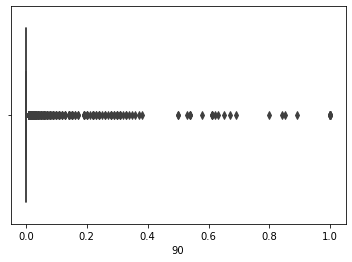

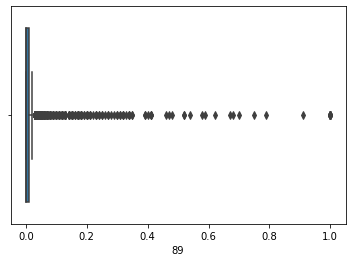

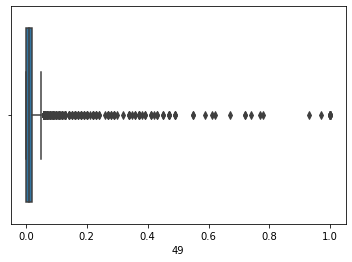

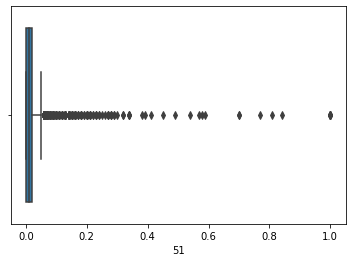

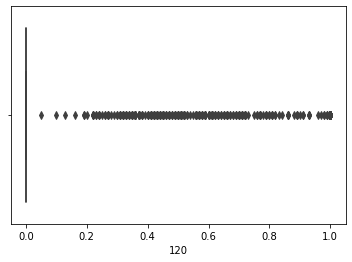

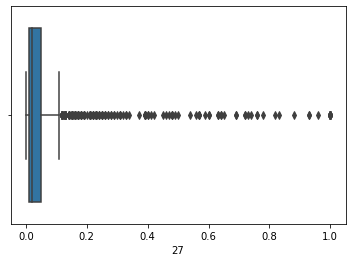

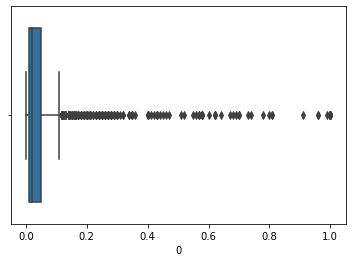

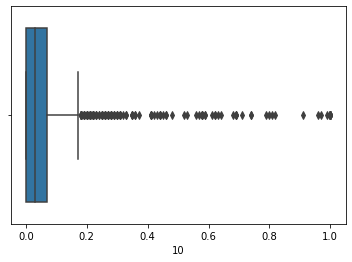

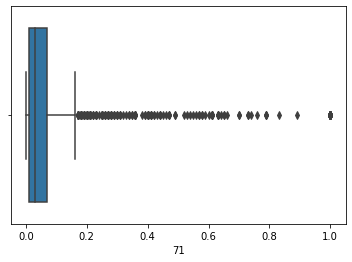

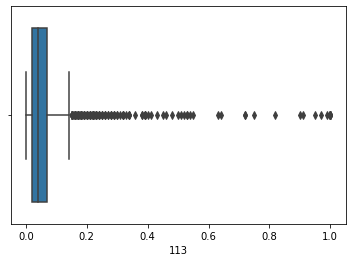

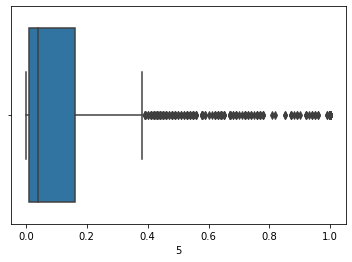

In [30]:
array = np.array(cv.iloc[0, :])
highest_cv = array.argsort()[-11:][::-1]
for i in highest_cv:
    plt.figure()
    sns.boxplot(df.iloc[:, i])


## f) Vanilla Linear Model

**Notice the highly negative R^2 from the model**. This means that the model does not fit the data at all. Upon further investigation, it turns out that there is a variable LemasSwFTPerPop that completely disrupts the model.

This probably means it's a good idea to do penalized regression (as has been done in g and h)

In [14]:
# Splitting train and test
train_set = df.loc[:1494]
test_set = df.loc[1495:]

train_X = train_set.iloc[:, :-1]
train_y = train_set.iloc[:, -1]
test_X = test_set.iloc[:, :-1]
test_y = test_set.iloc[:, -1]

In [15]:
vanilla = linear_model.LinearRegression().fit(train_X, train_y)
prediction = vanilla.predict(test_X)
print('R^2 score: ' + str(vanilla.score(test_X, test_y)))
print('MSE: ' + str(mean_squared_error(test_y, prediction)))

R^2 score: -15.606466950754836
MSE: 0.7897255274336176


## g) Ridge Regression Model

In [50]:
alpha = np.logspace(-4, 4, 50)
ridge = linear_model.RidgeCV(alphas=alpha, cv=5).fit(train_X, train_y)

prediction = ridge.predict(test_X)
print('R^2 score: ' + str(ridge.score(test_X, test_y)))
print('MSE: ' + str(mean_squared_error(test_y, prediction)))

R^2 score: 0.6301602314652566
MSE: 0.017587841359522374


## h) Lasso Model
**Comparison of Unstandardized and Standardized features**: It seems like both of them have very similar R^2 scores and MSE. The unstandardized features do slighly better, though it's almost negligible, and perhaps could be attributed to the specific search space. If the possible list of alphas were expanded, the results could have been different.

### i. Unstandardized features
**Note on Important Variables List**: This list corresponds to the column indices in the dataframe

In [53]:
lasso = linear_model.LassoCV(alphas=alpha, cv=5).fit(train_X, train_y)

prediction = lasso.predict(test_X)
print('R^2 score: ' + str(lasso.score(test_X, test_y)))
#print('R^2 score: ' + str(skm.r2_score(test_y, prediction)))
print('MSE: ' + str(mean_squared_error(test_y, prediction)))

R^2 score: 0.6259053074097357
MSE: 0.017790185551932514


In [57]:
# Feature Selection
important_features = SelectFromModel(estimator=linear_model.LassoCV(alphas=alpha, cv=5)).fit(train_X, train_y)
variables = important_features.get_support()
variables = [i for i, j in enumerate(variables) if j == True]
print('Important Variables: ' + str(variables))

Important Variables: [2, 4, 6, 7, 9, 11, 13, 14, 15, 16, 17, 18, 21, 22, 23, 24, 25, 26, 28, 29, 31, 33, 34, 36, 38, 39, 40, 44, 45, 46, 48, 49, 50, 51, 55, 59, 61, 63, 64, 67, 68, 69, 70, 71, 72, 74, 75, 76, 77, 78, 79, 82, 85, 86, 87, 88, 89, 90, 91, 94, 99, 100, 102, 104, 105, 106, 107, 108, 110, 111, 112, 113, 114, 115, 116, 118, 119, 120]


### ii. Standardized Features

In [51]:
# We only standardize the predictors (X)
scaler = preprocessing.StandardScaler()
train_X_std = scaler.fit_transform(train_X)
test_X_std = scaler.fit_transform(test_X)

# lasso with standardized features did not converge, so I raised the tolerance
lasso = linear_model.LassoCV(alphas=alpha, cv=5, tol=0.1).fit(train_X_std, train_y)

prediction = lasso.predict(test_X_std)
print('R^2 score: ' + str(lasso.score(test_X_std, test_y)))
print('MSE: ' + str(mean_squared_error(test_y, prediction)))

R^2 score: 0.6234954153131211
MSE: 0.01790478869495509


In [67]:
# Feature Selection
important_features = SelectFromModel(estimator=linear_model.LassoCV(alphas=alpha, cv=5, tol=0.1)).fit(train_X_std, train_y)
variables = important_features.get_support()
variables = [i for i, j in enumerate(variables) if j == True]
print('Important Variables: ' + str(variables))

Important Variables: [0, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 18, 19, 20, 21, 22, 23, 24, 25, 26, 28, 29, 30, 31, 33, 34, 35, 36, 38, 39, 40, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 54, 55, 56, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 82, 83, 84, 85, 86, 87, 88, 89, 90, 94, 97, 99, 100, 102, 103, 104, 105, 106, 108, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 121]


## i) PCR

Chosen M: 96

In [27]:
M = [int(i) for i in np.linspace(1, 122, 122)]
parameters = {'pca__n_components':M}

pca = PCA()
lr = linear_model.LinearRegression()

pipe = Pipeline(steps=[('pca', pca), ('lr', lr)])

pcr_cv = GridSearchCV(estimator=pipe, param_grid=parameters, n_jobs=-1, cv=5)
pcr_cv.fit(train_X, train_y)
print('M # of components: ' + str(pcr_cv.best_params_['pca__n_components']))
print('R^2 score: ' + str(pcr_cv.score(test_X, test_y)))
prediction = pcr_cv.predict(test_X)
print('MSE: ' + str(mean_squared_error(test_y, prediction)))

M # of components: 96
R^2 score: 0.6114024460405183
MSE: 0.01847987348363199


## j) XGBoost to Fit a Boosting Tree

In [16]:
tree_regressor = XGBRegressor(reg_lambda=0)
parameters = {'reg_alpha': np.logspace(-4, 4, 50)}

xgb_cv = GridSearchCV(estimator=tree_regressor, param_grid=parameters, cv=5, n_jobs=-1)

xgb_cv.fit(train_X, train_y)
print('Chosen alpha: ' + str(xgb_cv.best_params_['reg_alpha']))
print('R^2 score: ' + str(xgb_cv.score(test_X, test_y)))
prediction = xgb_cv.predict(test_X)
print('MSE: ' + str(mean_squared_error(test_y, prediction)))

Chosen alpha: 3.727593720314938
R^2 score: 0.621526025640849
MSE: 0.017998443612781346


# 2. Tree-Based Methods

Using the APS Failure Data

In [23]:
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
import random

Using TensorFlow backend.


In [56]:
test_set = pd.read_csv('../data/aps_failure_test_set.csv')
train_set = pd.read_csv('../data/aps_failure_training_set.csv')

## b) Data Preparation

### i. Techniques for Data Imputation
- Using the mean and median from the known values
- Using mode (most frequent value)
- Using kNN based on other features
- Using Hot-deck imputation: randomly choosing missing value from a set of similar variables
- Using Cold-deck imputation: systematically choosing missing value from a set of similar variables
- Using Interpolation and extrapolation: An estimated value from other observations of the same individual
- Using Stochastic regression imputation: predict missing values by regressing it from other related variables

**I will be doing mean imputation**

In [14]:
buffer = pd.concat([test_set, train_set], ignore_index=True)
buffer = buffer.replace({'na': np.nan})
buffer.iloc[:, 1:] = SimpleImputer().fit_transform(buffer.iloc[:, 1:])
buffer = pd.DataFrame(buffer)

In [15]:
# split back to train and test sets
test_set = buffer[:16000]
train_set = buffer[16000:].reset_index().drop(columns=['index'])

## ASIDE: Balanced Subsampling function
The following is a balanced subsampling method I created to sample the same ratio of majority to minority class. This will be used in the WEKA Wrapper section because passing in the entire dataset takes too much time

In [40]:
def subsample_balanced(pct, train_set):
    neg_class = train_set[train_set['class'] == 'neg'].reset_index().drop(columns=['index'])
    pos_class = train_set[train_set['class'] == 'pos'].reset_index().drop(columns=['index'])

    neg_indices = random.sample(range(1, len(neg_class)), int(np.floor(float(pct) * len(neg_class))))
    pos_indices = random.sample(range(1, len(pos_class)), int(np.floor(float(pct) * len(pos_class))))

    neg_class = neg_class.ix[neg_indices]
    pos_class = pos_class.ix[pos_indices]

    sub_train = pd.concat([neg_class, pos_class])
    
    return sub_train

""" PREPROCESSING CODE FOR WEKA
sub_train = subsample_balanced(0.15, train_set)
sub_test = subsample_balanced(0.15, test_set)

sub_train.to_csv('../data/weka_subsample_train.csv', index=False)
sub_test.to_csv('../data/weka_subsample_test.csv', index=False) 

test_set.to_csv('../data/weka_test.csv', index=False)
train_set.to_csv('../data/weka_train.csv', index=False)

test_set = pd.read_csv('../data/weka_test.csv')
y = test_set['class']
test_set = test_set.drop(columns=['class'])
test_set['class'] = y
test_set.to_csv('../data/weka_test_reversed.csv', index=False)"""

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  if __name__ == '__main__':


### ii. Coefficient of Variation (CV)

In [43]:
cv = buffer.iloc[:, 1:].apply(lambda x: np.std(x) / np.mean(x))
cv = pd.DataFrame(cv).T
cv

,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,4.328579,2.178258,2.167639,206.72014,22.293524,18.208896,91.460052,42.084066,17.625793,8.753242,...,2.603596,2.573275,2.62539,2.858242,3.230988,4.885066,3.335015,5.753895,47.919228,45.65065


### iii. Correlation Matrix

In [44]:
buffer.iloc[:, 1:].corr()

,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
aa_000,1.000000,0.019725,-0.011658,-0.000541,0.025795,0.035994,0.011682,0.076378,0.195161,0.307443,...,0.414125,0.419912,0.409659,0.419780,0.425679,0.356969,0.259668,0.133764,0.006688,0.010330
ab_000,0.019725,1.000000,-0.010898,0.000066,0.024869,0.043276,0.000590,0.006547,0.023484,0.035696,...,0.025161,0.037052,0.028766,0.034201,0.023921,0.013598,0.002371,0.000506,0.046897,0.075683
ac_000,-0.011658,-0.010898,1.000000,-0.002030,-0.004769,-0.010612,0.015534,-0.002333,-0.009439,-0.022889,...,-0.009808,-0.006437,-0.007962,-0.008115,-0.014680,-0.018631,0.010435,0.017293,-0.006191,0.015826
ad_000,-0.000541,0.000066,-0.002030,1.000000,-0.000195,-0.000236,-0.000038,-0.000034,-0.000093,-0.000223,...,-0.000883,-0.000921,-0.000908,-0.000730,-0.000745,-0.000462,-0.000794,-0.000500,-0.000082,-0.000091
ae_000,0.025795,0.024869,-0.004769,-0.000195,1.000000,0.829986,-0.000441,-0.000609,0.001948,0.020678,...,0.012751,0.019441,0.012847,0.026437,0.066533,0.036619,-0.008393,-0.006952,0.063587,0.030854
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ee_007,0.356969,0.013598,-0.018631,-0.000462,0.036619,0.046482,0.007631,0.068003,0.181967,0.475570,...,0.442199,0.432911,0.419633,0.380132,0.543449,1.000000,0.227098,0.063065,-0.000309,0.000946
ee_008,0.259668,0.002371,0.010435,-0.000794,-0.008393,-0.010843,0.000067,0.005353,0.009109,0.020684,...,0.442532,0.470574,0.448390,0.394020,0.365686,0.227098,1.000000,0.690147,-0.005173,-0.001950
ee_009,0.133764,0.000506,0.017293,-0.000500,-0.006952,-0.008539,-0.001103,-0.003540,-0.009089,-0.018164,...,0.224587,0.235844,0.220785,0.183844,0.158590,0.063065,0.690147,1.000000,-0.003168,-0.001059
ef_000,0.006688,0.046897,-0.006191,-0.000082,0.063587,0.093474,-0.000076,0.001140,0.005625,0.011036,...,0.003718,0.010177,0.002989,0.026924,0.005298,-0.000309,-0.005173,-0.003168,1.000000,0.222579


### iv. Plotting 13 Features with Highest CV
**Analysis**: The features with the highest variation skew toward 0 (because the middle of the box plots represent the middle quartiles. Perhaps this means that these features are not important in determining the output.

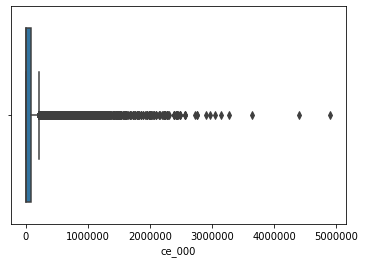

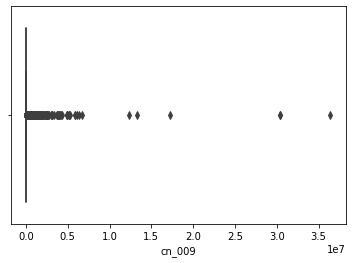

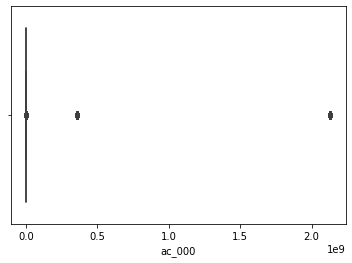

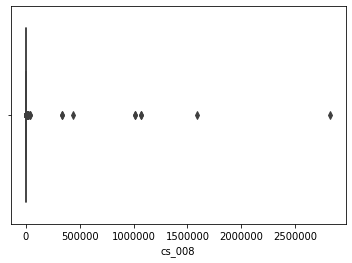

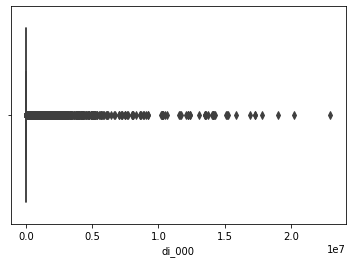

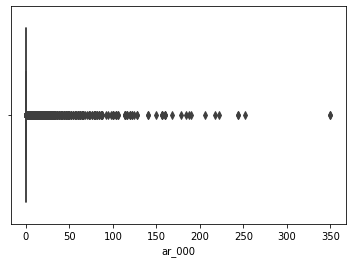

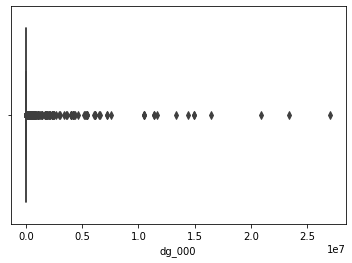

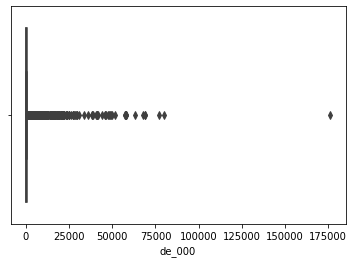

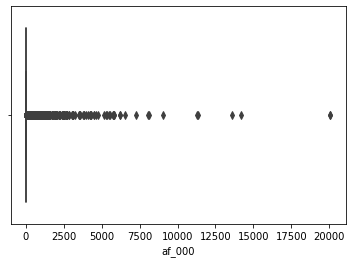

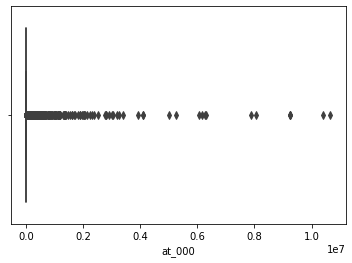

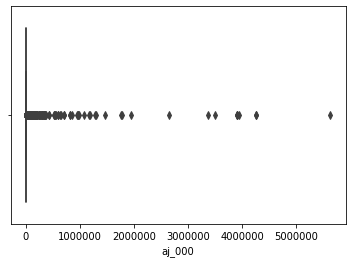

In [45]:
num_highest = np.floor(np.sqrt(170))
array = np.array(cv.iloc[0, :])
highest_cv = array.argsort()[-11:][::-1]
for i in highest_cv:
    plt.figure()
    sns.boxplot(buffer.iloc[:, i])

### v. Analysis of Imbalance
The data, both in the training and test datasets, are highly imbalanced.

In [46]:
print("Total (Test + Train Combined): ")
print(buffer['class'].value_counts())


print("Training Data: ")
print(train_set['class'].value_counts())

print("Test Data: ")
print(test_set['class'].value_counts())

Total (Test + Train Combined): 
neg    74625
pos     1375
Name: class, dtype: int64
Training Data: 
neg    59000
pos     1000
Name: class, dtype: int64
Test Data: 
neg    15625
pos      375
Name: class, dtype: int64


### ASIDE: Below are relevant functions that I will call frequently
1. **metrics_display(model, X, y)**:
    - Prints out the misclassification rate, confusion matrix, ROC and AUC

In [66]:
def metrics_display(model, X, y):
    print("Misclassification Rate: " + str(1-model.score(X, y)))

    prediction = model.predict(X)

    confusion_matrix = skm.confusion_matrix(y, prediction)
    print("Confusion Matrix:")
    print(confusion_matrix)
    
    tn, fp, fn, tp = skm.confusion_matrix(y, prediction).ravel()
    
    print("TPR: " + str(float(tp)/float(tp+fn)))

    predict_prob = model.predict_proba(X)
    positive_prob = predict_prob[:, 1]
    fpr, tpr, _ = skm.roc_curve(y, positive_prob, pos_label='pos')

    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([-0.02, 1.0])
    plt.ylim([0.0, 1.02])
    plt.title("ROC Curve")
    plt.show()

    auc = skm.auc(fpr, tpr)
    print("Area Under Curve: " + str(auc))

## c) Random Forest (without compensating for class imbalance)

**Comparison of Test Error vs. OOB Error**: 
    - Test error: 0.0089
    - OOB Error: 0.0092
The two errors are very similar. This is unsurprising, and in fact the hope is that OOB error will reflect test error. This means that in training and bagging our random forest, we got an accurate representation of what the test set will be like. As such, the tree performs just as well out of bag as it does with the test set

In [48]:
train_X = train_set.drop(columns=['class'])
train_y = train_set['class']

test_X = test_set.drop(columns=['class'])
test_y = test_set['class']

/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:460: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:465: RuntimeWarning: divide by zero encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:465: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


Train Set Metrics:
Misclassification Rate: 0.0006166666666667098
Confusion Matrix:
[[58999     1]
 [   36   964]]
TPR: 0.964
PPV: 0.9989637305699481


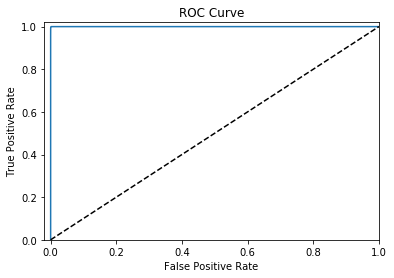

Area Under Curve: 0.9999938305084746

Test Set Metrics:
Misclassification Rate: 0.008937500000000043
Confusion Matrix:
[[15606    19]
 [  124   251]]
TPR: 0.6693333333333333
PPV: 0.9296296296296296


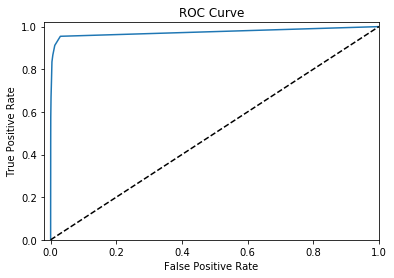

Area Under Curve: 0.9745769813333334

Out of Bag Error Estimate: 0.00921666666666665


In [64]:
rfr = RandomForestClassifier(oob_score=True).fit(train_X, train_y)

print("Train Set Metrics:")
metrics_display(rfr, train_X, train_y)

print("\nTest Set Metrics:")
metrics_display(rfr, test_X, test_y)

print("\nOut of Bag Error Estimate: " + str(1-rfr.oob_score_))

## d) Dealing with Class Imbalance in Random Forests
### i. Downsampling the majority class to balance the pos/neg classes
**Observations**: On face value, the misclassification rate seems to increase. However, notice from the confusion matrix that the misclassification rate on the positive class is significantly improved:
    - TPR for Vanilla Random Forest (Test Set): 0.6693
    - TPR for Downsampled Random Forest (Test Set): 0.986
If we are only interested in predicting failures (i.e. positive class), then we can say that the downsampling approach is a significant improvement.

Train Set Metrics:
Misclassification Rate: 0.055916666666666615
Confusion Matrix:
[[55659  3341]
 [   14   986]]
TPR: 0.986
PPV: 0.22787150450658655


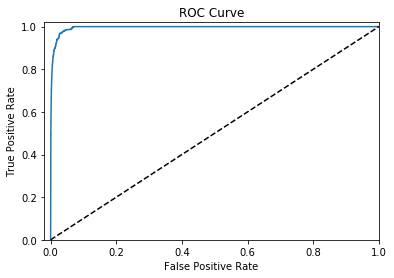

Area Under Curve: 0.9955977033898304

Test Set Metrics:
Misclassification Rate: 0.053875000000000006
Confusion Matrix:
[[14770   855]
 [    7   368]]
TPR: 0.9813333333333333
PPV: 0.3008994276369583


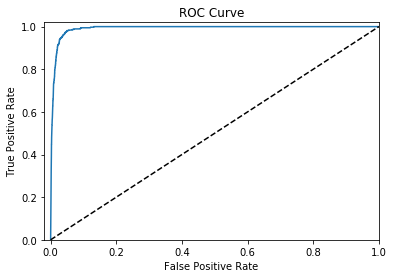

Area Under Curve: 0.9912128000000001

Out of Bag Error Estimate: 0.055433333333333334


In [65]:
rfr = BalancedRandomForestClassifier(oob_score=True).fit(train_X, train_y)
print("Train Set Metrics:")
metrics_display(rfr, train_X, train_y)

print("\nTest Set Metrics:")
metrics_display(rfr, test_X, test_y)

print("\nOut of Bag Error Estimate: " + str(1-rfr.oob_score_))

### ii. By applying class weights, adjusted by the number of occurrences (Another experiment)
**Observations**: Not only did the misclassification rate go up, but the TPR went down, which means that applying class weights was not an effective means of adjusting for class imbalance
    - TPR for Vanilla Random Forest (Test Set): 0.6693
    - TPR for Weighted Random Forest (Test Set): 0.5222

/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:460: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:465: RuntimeWarning: divide by zero encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:465: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


Train Set Metrics:
Misclassification Rate: 0.0010000000000000009
Confusion Matrix:
[[58998     2]
 [   58   942]]
TPR: 0.942


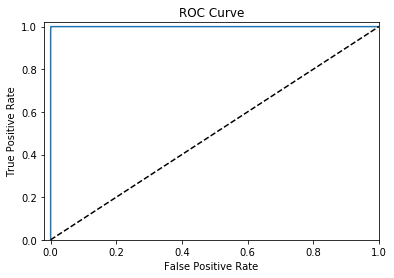

Area Under Curve: 0.9999918644067797

Test Set Metrics:
Misclassification Rate: 0.012249999999999983
Confusion Matrix:
[[15608    17]
 [  179   196]]
TPR: 0.5226666666666666


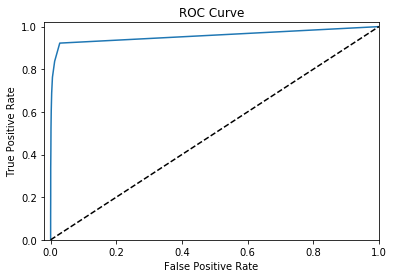

Area Under Curve: 0.95707264

Out of Bag Error Estimate: 0.01034999999999997


In [67]:
rfr = RandomForestClassifier(oob_score=True, class_weight='balanced').fit(train_X, train_y)

print("Train Set Metrics:")
metrics_display(rfr, train_X, train_y)

print("\nTest Set Metrics:")
metrics_display(rfr, test_X, test_y)

print("\nOut of Bag Error Estimate: " + str(1-rfr.oob_score_))

## e) Model Trees

**Explanation of Method**: I used the WEKA Python Wrapper to ubild a Logistic Model Tree using 10-fold cross validation. Passing in the entire training set proved to be time-consuming (I ran it for more than 20 hours and it still did not finish), so since my laptop was clearly wearing out, I decided to subsample. Since the classes were imbalanced, I took 15% of both the positive and negative classes so even the subsample reflected the ratio of majority:minority class.

In [2]:
import weka.core.jvm as jvm
jvm.start(packages=True)

DEBUG:weka.core.jvm:Adding bundled jars
DEBUG:weka.core.jvm:Classpath=['/opt/anaconda3/lib/python3.7/site-packages/javabridge/jars/rhino-1.7R4.jar', '/opt/anaconda3/lib/python3.7/site-packages/javabridge/jars/runnablequeue.jar', '/opt/anaconda3/lib/python3.7/site-packages/javabridge/jars/cpython.jar', '/opt/anaconda3/lib/python3.7/site-packages/weka/lib/python-weka-wrapper.jar', '/opt/anaconda3/lib/python3.7/site-packages/weka/lib/weka.jar']
DEBUG:weka.core.jvm:MaxHeapSize=default
DEBUG:weka.core.jvm:Package support enabled


In [8]:
from weka.classifiers import Classifier, Evaluation
from weka.core.converters import Loader, Saver
loader = Loader(classname="weka.core.converters.CSVLoader")
from weka.core.classes import Random
import weka.plot.classifiers as plcls  # NB: matplotlib is required

In [9]:
def weka_LMT(train_path, test_path, last):
    train_set = loader.load_file(train_path)
    test_set = loader.load_file(test_path)
    if last:
        train_set.class_is_last()
        test_set.class_is_last()
    else:
        train_set.class_is_first()
        test_set.class_is_first()
    
    classifier = Classifier(classname="weka.classifiers.trees.LMT")
    evl = Evaluation(train_set)
    evl.crossvalidate_model(classifier, train_set, 10, Random(1))
    print(evl.summary(title="cross-validation"))

    classifier.build_classifier(train_set)
    
    evl_test = Evaluation(test_set)
    evl_test.test_model(classifier, test_set)
    print(evl_test.summary(title="test"))

    print(evl_test.confusion_matrix)
    print(evl_test.area_under_roc)
    plcls.plot_roc(evl_test, class_index=[0, 1], wait=True)

cross-validation
Correctly Classified Instances        8901               98.9    %
Incorrectly Classified Instances        99                1.1    %
Kappa statistic                          0.6064
Mean absolute error                      0.0155
Root mean squared error                  0.0956
Relative absolute error                 47.1092 %
Root relative squared error             74.6531 %
Total Number of Instances             9000     

test
Correctly Classified Instances       15767               98.5438 %
Incorrectly Classified Instances       233                1.4563 %
Kappa statistic                          0.6798
Mean absolute error                      0.0162
Root mean squared error                  0.1132
Relative absolute error                 35.4231 %
Root relative squared error             74.7989 %
Total Number of Instances            16000     

[[15511.   114.]
 [  119.   256.]]
<bound method Evaluation.area_under_roc of weka.classifiers.Evaluation@54befcea>


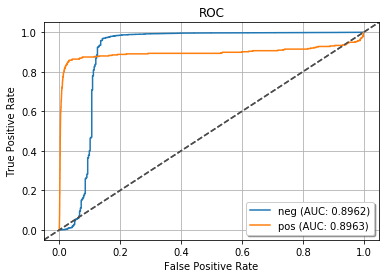

In [44]:
weka_LMT('../data/weka_subsample_train.csv', '../data/weka_test.csv', False)

## f) Model Trees with Balanced Training Set

In [44]:
from imblearn.over_sampling import SMOTE

def smote_apply(input_file, output_file, pct):
    train_set = pd.read_csv('../data/weka_train.csv')

    train_X = train_set.drop(columns=['class'])
    train_y = train_set['class']

    smote = SMOTE(sampling_strategy=1.0)
    trainX_smote, trainy_smote = smote.fit_resample(train_X, train_y)
    
    trainX_smote = pd.DataFrame(trainX_smote, columns=train_X.columns)
    trainy_smote = pd.DataFrame(trainy_smote, columns=['class'])

    train_smote = trainX_smote
    train_smote['class'] = trainy_smote

    train_smote.to_csv('../data/weka_train_smote.csv', index=False)
    
    sub_train_smote = subsample_balanced(float(pct), train_smote)
    sub_train_smote.to_csv('../data/weka_train_smote_subsample.csv', index=False)

In [6]:
from imblearn.under_sampling import RandomUnderSampler

def down_sample(ratio):
    train_set = pd.read_csv('../data/weka_train.csv')

    train_X = train_set.drop(columns=['class'])
    train_y = train_set['class']

    downsample = RandomUnderSampler(sampling_strategy=ratio)
    trainX_smote, trainy_smote = downsample.fit_resample(train_X, train_y)
    
    trainX_smote = pd.DataFrame(trainX_smote, columns=train_X.columns)
    trainy_smote = pd.DataFrame(trainy_smote, columns=['class'])

    train_smote = trainX_smote
    train_smote['class'] = trainy_smote
    
    train_smote.to_csv('../data/weka_train_downsample1.csv', index=False)
    
down_sample(0.16666666)

### i. SMOTE (subsampled)
I employed the same method (LMT with 10-fold cross validation), this time with a balanced training set. 

SMOTE on the entire dataset took way too long (I ran it for over a day). Instead, I used SMOTE to upsample the minority class, then picked a balanced subsample of 10%. This means that I took an even 50:50 from both classes, but just took 10% of the total dataset.

Also, the original SMOTE dataset could not be uploaded to Github because it took more than 200MB.

**Discussion of Results: The SMOTE model did better in predicting the positive class.**

Test Errors:
    - Unbalanced: 0.0145
    - SMOTE: 0.043
True Positive Rate:
    - Unbalanced: 0.683
    - **SMOTE: 0.952**
    
Naively, if we look at just test errors, SMOTE did worse (3 percentage points worse). But we presumably care more about predicting failures, in which case the SMOTE method prevailed.

#### **Refer to the cells at the end of the notebook for a more comprehensive analysis/comparison**

In [13]:
train_set_smote = loader.load_file('../data/weka_train_smote_subsample.csv')
train_set_smote.class_is_last()
test_set = loader.load_file('../data/weka_test_reversed.csv')
test_set.class_is_last()

In [6]:
classifier = Classifier(classname="weka.classifiers.trees.LMT")
eval_smote = Evaluation(train_set_smote)
eval_smote.crossvalidate_model(classifier, train_set_smote, 10, Random(1))
print(eval_smote.summary(title="cross-validation"))

classifier.build_classifier(train_set_smote)

cross-validation
Correctly Classified Instances       11522               97.6441 %
Incorrectly Classified Instances       278                2.3559 %
Kappa statistic                          0.9529
Mean absolute error                      0.0336
Root mean squared error                  0.1388
Relative absolute error                  6.7151 %
Root relative squared error             27.7538 %
Total Number of Instances            11800     



test
Correctly Classified Instances       15312               95.7    %
Incorrectly Classified Instances       688                4.3    %
Kappa statistic                          0.4918
Mean absolute error                      0.0621
Root mean squared error                  0.1864
Relative absolute error                135.4699 %
Root relative squared error            123.204  %
Total Number of Instances            16000     

[[14955.   670.]
 [   18.   357.]]
<bound method Evaluation.area_under_roc of weka.classifiers.Evaluation@6bdc7421>


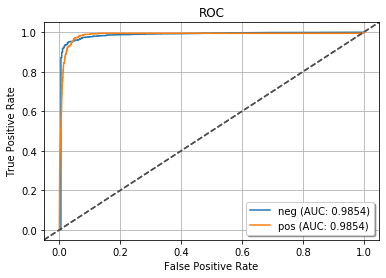

In [24]:
evl_test_smote = Evaluation(test_set)
evl_test_smote.test_model(classifier, test_set)
print(evl_test_smote.summary(title="test"))

print(evl_test_smote.confusion_matrix)
print(evl_test_smote.area_under_roc)
plcls.plot_roc(evl_test_smote, class_index=[0, 1], wait=True)

### ii. Downsampling (1:6 ratio)
As per the footnote description, I downsapled the majority (neg) class to 6,000. This makes a slightly less unbalanced training data with a 1:6 ratio

**Discussion of Results**: Using this training set is arguably one of the better ones. This is because it achieves a relatively low test error rate (0.0155) while also accuratively predicting positive classes.

cross-validation
Correctly Classified Instances        6763               96.6143 %
Incorrectly Classified Instances       237                3.3857 %
Kappa statistic                          0.8597
Mean absolute error                      0.0472
Root mean squared error                  0.1652
Relative absolute error                 19.2522 %
Root relative squared error             47.2132 %
Total Number of Instances             7000     

test
Correctly Classified Instances       15751               98.4437 %
Incorrectly Classified Instances       249                1.5562 %
Kappa statistic                          0.7159
Mean absolute error                      0.0329
Root mean squared error                  0.114 
Relative absolute error                 71.741  %
Root relative squared error             75.3663 %
Total Number of Instances            16000     

[[15425.   200.]
 [   49.   326.]]
<bound method Evaluation.area_under_roc of weka.classifiers.Evaluation@6385f7cd>


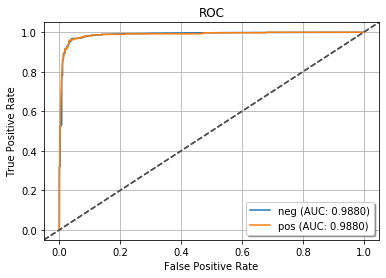

In [10]:
weka_LMT('../data/weka_train_downsample1.csv', '../data/weka_test_reversed.csv', True)

## Evaluation of e and f) Comparison of All Methods

From the table below, there are clearly tradeoffs to all the methods. 
    - Unbalanced dataset has a pretty decent/equal recall and precision score at about 0.68
    - SMOTE did exceptionally well in recall but poorly in precision. This is perhaps because I subsampled only 10% of the data. Nonetheless, the results were still pretty satisfactory
    - Downsampling to 6,000 neg datapoints balances recall and precision the best. It has the highest F1 score, and a pretty decent recall compared to SMOTE
    
Ultimately, which model is best depends on the need. If we only care about predicting failures accurately (having enough resources to deal with a lot of false positives), then SMOTE could be good. On the other hand, if we also don't want a lot of false positives, downsampling might be better.

In [12]:
def calculate_metrics(model, tp, fp, fn):
    tp = float(tp)
    fp = float(fp)
    fn = float(fn)
    tpr = tp / (tp + fn)
    precision = tp / (tp + fp)
    f1 = 2 * (precision * tpr) / (precision + tpr)
    
    return [model, tpr, precision, f1]

simple_list=[]
simple_list.append(calculate_metrics('Unbalanced Dataset (15% from each class)', 256, 114, 119))
simple_list.append(calculate_metrics('SMOTE (10% from each class)', 357, 670, 18))
simple_list.append(calculate_metrics('Downsampling (6,000 & 1,000 from neg and pos class)', 326, 200, 49))

results_LMT = pd.DataFrame(simple_list, columns=['Model', 'Recall', 'Precision', 'F1'])
print(results_LMT)

                                               Model    Recall  Precision  \
0           Unbalanced Dataset (15% from each class)  0.682667   0.691892   
1                        SMOTE (10% from each class)  0.952000   0.347614   
2  Downsampling (6,000 & 1,000 from neg and pos c...  0.869333   0.619772   

         F1  
0  0.687248  
1  0.509272  
2  0.723640  


In [18]:
jvm.stop()

# 3. ISLR 6.8.3
![alt text](3.png "Solutions for 6.8.3")

# 4. ISLR 6.8.5
![alt text](4a.png "Solutions for 6.8.5")
![alt text](4b.png "Solutions for 6.8.5")

# 5. ISLR 8.4.5
![alt text](5.png "Solutions for 8.4.5")

# 6. ISLR 9.7.3
![alt text](6.png "Solutions for 9.7.3")


## For questions 3-6, sometimes Github doesn't display the alt_text. Just in case, you can find the answers in the notebook/ folder under 3, 4a, 4b, 5, 6.